# Problema 3

Esse problema se reduz a um dos problemas da lista anterior. Primeiro veja que para um estimador MAP, o problema se reduz à seguinte expressão:

$$\hat{x}_i = \arg\max_{x_i} f_{X|Y}(x_i|y),$$

e que para uma distribuição gaussiana chegamos na seguinte expressão:

$$
\begin{align*}
    \hat{x} &= \arg\max_{x_i} f_{Y|X}(y|x_i)p(x_i)\\ 
     &= \arg\max_i p(x_i) \cdot  \frac{1}{\pi N_0}e^{-\frac{|y-x_i|^2}{N_0}}\\
     &= \arg\max_{x_i} p(x_i) \cdot e^{-\frac{|y-x_i|^2}{N_0}}\\
     &= \arg\max_{x_i}\left[ \ln(p(x_i)) -\frac{|y-x_i|^2}{N_0}\right]\\
     &= \arg\max_{x_i}\left[ \frac{N_0}{2}\ln(p(x_i)) -\frac{1}{2}|y-x_i|^2\right]
\end{align*}
$$

No entanto, no caso dessa questão temos, onde temos que fazer a estimativa ML (ou seja, $p(x_i) = 1/M$), o único fator que importa é o da distância e logo se chega na expressão a seguir:

$$\hat{x}_i = \arg\min_{x_i}|y-x_i|^2.$$

Fizemos exatamente isso nos problemas da lista anterior, logo podemos facilmente pegar o código emprestado e resolver esse problema.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def QAMModem(M): # gray coding into constellation setup ahead
    n=np.arange(0,M) # symbols from 0 to M-1
    a=np.asarray([x^(x>>1) for x in n]) # convert linear to gray code
    D=np.sqrt(M).astype(int) # dimension of our map
    a=np.reshape(a,(D,D)) # slice array on a matrix D x D sized
    oddRows=np.arange(start=1,stop=D,step=2) # identify rows to flip
    a[oddRows,:]=np.fliplr(a[oddRows,:]) # flip the rows
    nGray=np.reshape(a,(M)) # reshape/flatten to 1xM array
    (x,y)=np.divmod(nGray,D) # element-wise quotient and remainder
    Ax=2*x+1-D
    Ay=2*y+1-D
    constellation = Ax + 1j*Ay
    return constellation

def plotConstellation(constellation,M):
    from math import log2
    fig, axs = plt.subplots(1, 1)
    axs.plot(np.real(constellation),np.imag(constellation),'o')
    for i in range(0,M):
        axs.annotate("{0:0{1}b}".format(i,int(log2(M))),(np.real(constellation[i]),np.imag(constellation[i])))
    axs.set_title('Constellation')
    axs.set_xlabel('I')
    axs.set_ylabel('Q')

def modulate(constellation,inputSymbols):
    modulatedVec = constellation[inputSymbols]
    return modulatedVec 

def awgn(s, SNRdB):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    P=np.sum(abs(s)**2)/len(s) # power in the vector -> P=sum (X^{2})/M
    N0=P/gamma # noise spectral density
    n = np.sqrt(N0/2)*(np.random.randn(len(s)) + 1j*np.random.randn(len(s))) # AWGN with unity power
    r = s + n # received signal + noise
    return r

In [3]:


def demodulate(constellation,receivedSyms):
    # received vector and reference in cartesian form
    from scipy.spatial.distance import cdist
    XA = np.column_stack((np.real(receivedSyms),np.imag(receivedSyms)))
    XB = np.column_stack((np.real(constellation),np.imag(constellation)))
        
    d = cdist(XA,XB,metric='euclidean') #compute pair-wise Euclidean distances
    detectedSyms=np.argmin(d,axis=1)#indices corresponding minimum Euclid. dist.
    return detectedSyms


def decode(demodulatedSyms,constellation):
    decodedSyms=np.zeros(len(demodulatedSyms))
    for i in np.arange(0,len(demodulatedSyms)):
        aux = demodulatedSyms[i]-constellation
        decodedSyms[i]=np.abs(aux).argmin()
    return decodedSyms

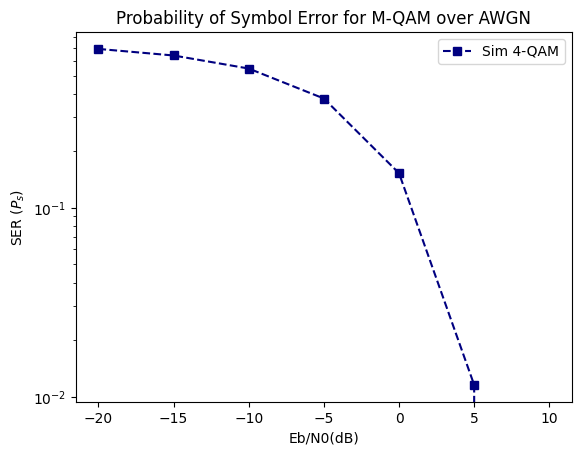

In [4]:
#---------Input Fields------------------------
nSym = np.int64(5e4) # Number of symbols to transmit # also, compile time for 10**6 is over 30s. for a quicker result do either 10**5 or 10**4
EbN0dBs = np.arange(start=-20,stop = 15, step = 5) # Eb/N0 range in dB for simulation
mod_type = 'QAM'
arrayOfM=[4] 

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    constellation = QAMModem(M)
    px = list(np.ones(M)/M) # probabilidade equiprovável
    rng = np.random.default_rng()

    for j,EsN0dB in enumerate(EsN0dBs):
        inputSyms=rng.integers(M, size=nSym)
        modulatedSyms = modulate(constellation,inputSyms) #modulate
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        detectedSyms=demodulate(constellation,receivedSyms)
        
        SER_sim[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    ax.semilogy(EbN0dBs,SER_sim,color = colors[i],marker='s',linestyle='--',label='Sim '+str(M)+'-'+mod_type.upper())


ax.set_xlabel('Eb/N0(dB)')
ax.set_ylabel('SER ($P_s$)')
ax.set_title('Probability of Symbol Error for M-'+str(mod_type)+' over AWGN')
ax.legend()
#ax.set_ylim(1e-6) # if you don't set the limit it will get goofy. leave this untouched.